**Animal Shelter Intake and Outcome**


> I have chosen to work with the Sonoma County data on Animal Shelter Intake and Outcome. I have downloaded the csv file because there is no link offered on the database site.



**Define Classification Problem**

---



*   Target to predict: Outcome Type - was the animal adopted or not?
*   This is a classification problem, the multi-classification column will be converted to boolean (binary classification) to minimize classifiers and combine multiple classifications with minimal counts.
*   Metric to be used will be **Accuracy**.





In [ ]:
# Load dataset

import pandas as pd
import numpy as np
%pip install --upgrade category_encoders

shelter_outcome = pd.read_csv('sample_data/Animal_Shelter_Intake_and_Outcome.csv')
shelter_outcome.head()

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)


,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaN,K20-035118,DS69,A395686,01/19/2020,01/23/2020,4,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,04/06/2015,K17-025093,DS83,A379968,08/30/2017,10/04/2017,35,STRAY,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1
2,BRATT,CAT,DOMESTIC SH,BRN TABBY,Spayed,SMALL,09/01/2010,K18-028633,MAC,A374010,06/13/2018,08/11/2018,59,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,MOB EVENT,TREATABLE/MANAGEABLE,HEALTHY,COUNTY,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1
3,DOONA,DOG,PIT BULL,TAN/WHITE,Male,LARGE,07/06/2016,K20-035573,DS67,A389249,03/11/2020,03/13/2020,2,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_NOTICE,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,"95409(38.458965, -122.630156)",0
4,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,01/23/2011,K15-012348,DA34,A315553,01/07/2015,01/24/2015,17,STRAY,OVER THE COUNTER,ADOPTION,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1


In [ ]:
shelter_outcome['Breed'].value_counts(normalize=True).nlargest(15)

DOMESTIC SH            0.274620
PIT BULL               0.077001
CHIHUAHUA SH           0.047771
GERM SHEPHERD          0.034802
PIT BULL/MIX           0.032725
DOMESTIC MH            0.032573
DOMESTIC LH            0.028926
CHIHUAHUA SH/MIX       0.023708
LABRADOR RETR          0.021074
RABBIT SH              0.015907
LABRADOR RETR/MIX      0.014944
GERM SHEPHERD/MIX      0.014438
SIBERIAN HUSKY         0.014134
CHICKEN                0.014134
PARSON RUSS TER/MIX    0.009524
Name: Breed, dtype: float64

In [ ]:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

In [ ]:
# Data Cleaning
# Change column names: replace spaces with underscores
shelter_outcome.columns = shelter_outcome.columns.str.replace(' ','_')

# column to be used for predictive model
shelter_outcome['Outcome_Type'].describe()
shelter_outcome['Outcome_Type'].value_counts(normalize=True)
shelter_outcome = shelter_outcome.dropna(subset=['Outcome_Type'])
shelter_outcome['Outcome_Type'].isnull().sum()

# add a binary column for True if ADOPTION and False if not for 'Outcome_Type'
shelter_outcome['Adopted'] = shelter_outcome['Outcome_Type'].map({'RETURN TO OWNER': 'Not Adopted',
                                                                  'ADOPTION': 'Adopted',
                                                                  'TRANSFER': 'Not Adopted',
                                                                  'EUTHANIZE': 'Not Adopted',
                                                                  'DIED': 'Not Adopted',
                                                                  'DISPOSAL': 'Not Adopted',
                                                                  'ESCAPED/STOLEN': 'Not Adopted',
                                                                  'RTOS':'Not Adopted'})
shelter_outcome['Adopted'].head(5)

# target distribution
y = shelter_outcome['Adopted']
y.value_counts(normalize=True)

# data exploration on Intake Type
shelter_outcome['Intake_Type'].unique()

# feature engineering
# convert to datetime - Date_Of_Birth and Outcome_Date
shelter_outcome['Date_Of_Birth'] = pd.to_datetime(shelter_outcome['Date_Of_Birth'])
shelter_outcome['Outcome_Date'] = pd.to_datetime(shelter_outcome['Outcome_Date'])

# convert some features to numerical value
shelter_outcome['Animal_Type'] = shelter_outcome['Type'].map({'DOG': 1,
                                    'CAT': 2,
                                    'OTHER': 3})
unknown = shelter_outcome[shelter_outcome['Sex']=='Unknown'].index
shelter_outcome.drop(unknown, inplace=True)
shelter_outcome['Gender'] = shelter_outcome['Sex'].map({'Male': 1,
                              'Female': 2,
                              'Neutered': 1,
                              'Spayed': 2})
shelter_outcome['Fixed'] = shelter_outcome['Sex'].map({'Male': 0,
                                                       'Female': 0,
                                                       'Neutered': 1,
                                                       'Spayed': 1})
shelter_outcome['Neutered_Spayed'] = shelter_outcome['Fixed'].map({1:'True',
                                                                   0:'False'})
shelter_outcome['Outcome_Condition'] = shelter_outcome['Outcome_Condition'].map({
    'HEALTHY': 'HEALTHY',
    'PENDING': 'PENDING',
    'TREATABLE/REHAB': 'TREATABLE',
    'TREATABLE/MANAGEABLE': 'TREATABLE',
    'UNTREATABLE': 'UNTREATABLE/DEAD',
    'DEAD': 'UNTREATABLE/DEAD'
})
shelter_outcome['Release_Condition'] = shelter_outcome['Outcome_Condition'].map({
    'HEALTHY':1,
    'PENDING': 2,
    'TREATABLE': 3,
    'UNTREATABLE/DEAD': 4
})

# minimize class on size
shelter_outcome['Size_2'] = shelter_outcome['Size'].map({'SMALL': 'S',
                               'MED': 'M',
                               'LARGE': 'L',
                               'KITTN' : 'S',
                               'TOY': 'XS',
                               'PUPPY': 'S',
                               'X-LRG': 'XL'})
shelter_outcome['Size_Num'] = shelter_outcome['Size_2'].map({'XS':1,
                                                             'S':2,
                                                             'M':3,
                                                             'L':4,
                                                             'XL':5})

# column for 'Age_On_Outcome'
shelter_outcome['Age_On_Outcome'] = shelter_outcome['Outcome_Date'] - shelter_outcome['Date_Of_Birth']
shelter_outcome['Age_On_Outcome'] = pd.to_numeric(shelter_outcome['Age_On_Outcome'].dt.days, downcast='integer')
shelter_outcome['Age_On_Outcome'] = shelter_outcome['Age_On_Outcome'] / 365

# high cardinality features
shelter_outcome = shelter_outcome.drop(columns=['Name', 'Impound_Number', 'Kennel_Number',
                                                'Animal_ID', 'Color', 'Location', 'Date_Of_Birth', 
                                                'Intake_Date'])
# drop nan values
shelter_outcome = shelter_outcome.dropna()

# time-based split using 'Intake_Date'
# convert to datetime

shelter_outcome['Outcome_Date'] = pd.to_datetime(shelter_outcome['Outcome_Date'])

# create 'Outcome_Year' column
shelter_outcome['Outcome_Year'] = shelter_outcome['Outcome_Date'].dt.year 


# split to training: 2013-2015, val: 2016-2018, test: 2019-2020
train = shelter_outcome[shelter_outcome['Outcome_Year'] <= 2015]
val = shelter_outcome[(shelter_outcome['Outcome_Year'] >= 2016) & (shelter_outcome['Outcome_Year'] >= 2018)]
test = shelter_outcome[shelter_outcome['Outcome_Year'] >=2019]


# shape of dataframes
train.shape, val.shape, test.shape

((4567, 26), (4259, 26), (2352, 26))

In [ ]:
# checking popular breeds - Top 20

shelter_adopted = shelter_outcome['Adopted'] == 'Adopted'
shelter_outcome['Breed'].value_counts(normalize=True).nlargest(20)

DOMESTIC SH            0.246181
PIT BULL               0.079361
CHIHUAHUA SH           0.057974
GERM SHEPHERD          0.038650
PIT BULL/MIX           0.035747
DOMESTIC MH            0.028796
CHIHUAHUA SH/MIX       0.027039
LABRADOR RETR          0.024748
DOMESTIC LH            0.023831
LABRADOR RETR/MIX      0.018637
SIBERIAN HUSKY         0.016422
GERM SHEPHERD/MIX      0.015353
PARSON RUSS TER/MIX    0.012145
RABBIT SH              0.011457
BORDER COLLIE/MIX      0.008937
SIAMESE                0.007791
PARSON RUSS TER        0.007180
SIAMESE/MIX            0.006645
BORDER COLLIE          0.006187
POODLE MIN             0.005805
Name: Breed, dtype: float64

In [ ]:
# Checking value counts of target to be used for blog post

shelter_outcome['Outcome_Type'].value_counts(normalize=True)

ADOPTION           0.461045
RETURN TO OWNER    0.368622
TRANSFER           0.143446
EUTHANIZE          0.025053
DISPOSAL           0.000840
DIED               0.000764
RTOS               0.000153
ESCAPED/STOLEN     0.000076
Name: Outcome_Type, dtype: float64

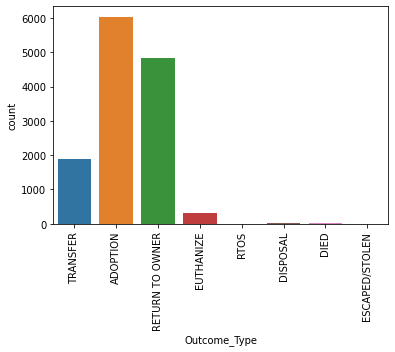

In [ ]:
# Target value counts visualization to be used for blog post

import seaborn as sns
import matplotlib.pyplot as plt

chart = sns.countplot(shelter_outcome['Outcome_Type'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

In [ ]:
# BASELINE: target distribution
y = shelter_outcome['Adopted']
y.value_counts(normalize=True)

Not Adopted    0.538955
Adopted        0.461045
Name: Adopted, dtype: float64

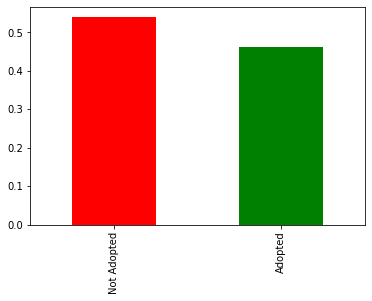

In [ ]:
prob = y.value_counts(normalize=True)
prob.plot(kind='bar', color =['red', 'green'])
plt.show()

**Fitting Linear Model**

---
Will be using Logistic Regression since I have a classification problem, and the probability range is between 1 and 0.


In [ ]:
# drop some columns to prevent "leakage"
shelter_outcome = shelter_outcome.drop(columns=['Outcome_Date', 'Outcome_Type', 'Adopted'])


shelter_outcome.head()

,Type,Breed,Sex,Size,Days_in_Shelter,Intake_Type,Intake_Subtype,Outcome_Subtype,Intake_Condition,Outcome_Condition,Intake_Jurisdiction,Outcome_Jurisdiction,Outcome_Zip_Code,Count,Animal_Type,Gender,Fixed,Neutered_Spayed,Release_Condition,Size_2,Size_Num,Age_On_Outcome,Outcome_Year
1,DOG,BEAGLE,Neutered,SMALL,35,STRAY,FIELD,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,1,1,1,1,True,1.0,S,2.0,2.498630,2017
2,CAT,DOMESTIC SH,Spayed,SMALL,59,OWNER SURRENDER,OVER THE COUNTER,MOB EVENT,TREATABLE/MANAGEABLE,HEALTHY,COUNTY,SANTA ROSA,95405.0,1,2,2,1,True,1.0,S,2.0,7.947945,2018
3,DOG,PIT BULL,Male,LARGE,2,STRAY,FIELD,OVER THE COUNTER_NOTICE,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,0,1,1,0,False,1.0,L,4.0,3.687671,2020
4,DOG,LABRADOR RETR/MIX,Spayed,LARGE,17,STRAY,OVER THE COUNTER,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,1,1,2,1,True,1.0,L,4.0,4.005479,2015
6,DOG,GOLDEN RETR,Neutered,LARGE,762,CONFISCATE,FLD_CRUEL,SCAS WEB,UNKNOWN,PENDING,COUNTY,COUNTY,95401.0,1,1,1,1,True,2.0,L,4.0,8.090411,2020


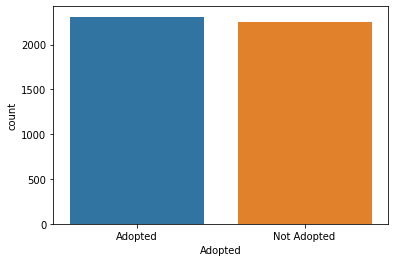

In [ ]:
# majority class

import seaborn as sns
import matplotlib.pyplot as plt

target = 'Adopted'
y_train = train[target]

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

sns.countplot(y_train);

In [ ]:
# baseline accuracy

from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5060214582877163

In [ ]:
# baseline accuracy score

y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.3883540737262268

In [ ]:
# Fitting linear model - Logistic Regression

# 1. Import estimator class
from sklearn.linear_model import LogisticRegression

# 2. Instantiate this class
log_reg = LogisticRegression(solver='lbfgs')

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Animal_Type', 'Fixed',
            'Size_Num', 'Release_Condition', 'Age_On_Outcome']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
log_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.8175628081709322


In [ ]:
log_reg.coef_

array([[-0.5684358 , -3.55196967,  0.4892969 ,  0.39923274,  0.18272451]])

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model = LogisticRegression()

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)

accuracy_score(y_val, y_pred)

coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients

Animal_Type         -0.320742
Fixed               -1.314743
Size_Num             0.450258
Release_Condition    0.266602
Age_On_Outcome       0.675125
dtype: float64

In [ ]:
# Prediction for New Data

Animal_Type = 1
Gender = 2
Size_Num = 4
Release_Condition = 3
Age_On_Outcome = 2

X_test = [[Animal_Type, Gender, Size_Num, Release_Condition, Age_On_Outcome]]
y_pred = model.predict(X_test)

y_pred

array(['Not Adopted'], dtype=object)

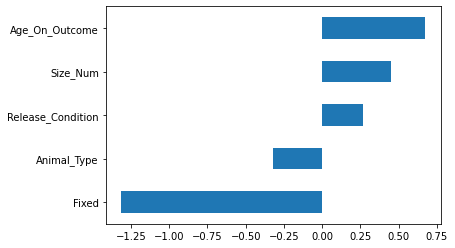

In [ ]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

**Fit and Evaluate a tree-based model**

---
Using Random Forest Classifier


In [ ]:
# evaluation metric = accuracy

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# target
target = 'Adopted'

# set features
features = ['Type', 'Neutered_Spayed', 'Size_2', 'Outcome_Condition', 'Age_On_Outcome']

# define X_train, y_train, X_val, and y_val
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# define pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# run pipeline on training
pipeline.fit(X_train, y_train)

# print validation accuracy
print('Accuracy', pipeline.score(X_val, y_val))

Accuracy 0.7792909133599436


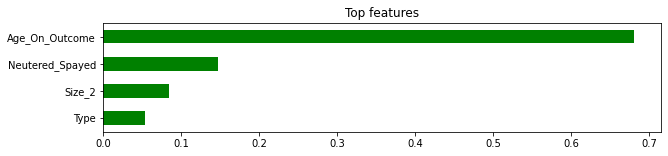

In [ ]:
# getting feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# plot feature importances
import matplotlib.pyplot as plt

n=4
plt.figure(figsize=(10,n/2))
plt.title(f'Top features')
importances.sort_values()[-n:].plot.barh(color='green');

In [ ]:
# Test Score with Random Forest Classifier
from sklearn.metrics import roc_auc_score

# drop the column with leakage
features = ['Type', 'Neutered_Spayed', 'Size_2', 'Outcome_Condition', 'Age_On_Outcome']

X_test = test[features]
y_test = test[target]

# define pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# run pipeline on test
pipeline.fit(X_test, y_test)

# print validation accuracy
print('Accuracy', pipeline.score(X_test, y_test))

# predicted probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, -1]

# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc)

Accuracy 0.9834183673469388
AUC: 0.9974341750884933


Second & Final Model: XGB Classifier

In [ ]:
# xgboost for gradient boosting

from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8239023244893168


In [ ]:
# Test Score with XGB Classifier

from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_test, y_test)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.8465136054421769


In [ ]:
y_pred_proba

array([1.  , 0.42, 0.  , ..., 0.75, 0.69, 1.  ])

**Make Visualizations for Predictive Modeling**

In [ ]:
# PDP for 1 feature

# X = X_test
# y = y_test

# encoder = ce.OrdinalEncoder()
# X_encoded = encoder.fit_transform(X)

# model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# model.fit(X_encoded, y)

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from pdpbox import pdp

# pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)

# feature = 'Neutered_Spayed'
# for item in encoder.mapping:
#     if item['col'] == feature:
#         feature_mapping = item['mapping']
        
# feature_mapping = feature_mapping[feature_mapping.index.dropna()]
# category_names = feature_mapping.index.tolist()
# category_codes = feature_mapping.values.tolist()

# pdp.pdp_plot(pdp_dist, feature)

# plt.xticks(category_codes, category_names);

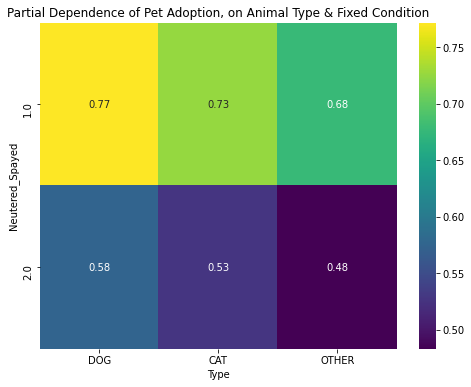

In [ ]:
# PDP interact 2 features

from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Type', 'Neutered_Spayed', 'Size_2', 'Outcome_Condition', 'Age_On_Outcome']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)
pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(8, 6))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Pet Adoption, on Animal Type & Fixed Condition');

In [ ]:
encoder.mapping

[]

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)



import shap

row = X_test.iloc[[35]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' 
)

[0]	validation_0-auc:0.8052	validation_1-auc:0.863886
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.825471	validation_1-auc:0.887412
[2]	validation_0-auc:0.825914	validation_1-auc:0.883543
[3]	validation_0-auc:0.825597	validation_1-auc:0.882964
[4]	validation_0-auc:0.83325	validation_1-auc:0.894324
[5]	validation_0-auc:0.833837	validation_1-auc:0.894824
[6]	validation_0-auc:0.835835	validation_1-auc:0.895517
[7]	validation_0-auc:0.836361	validation_1-auc:0.895254
[8]	validation_0-auc:0.836779	validation_1-auc:0.895273
[9]	validation_0-auc:0.838837	validation_1-auc:0.897672
[10]	validation_0-auc:0.840565	validation_1-auc:0.900785
[11]	validation_0-auc:0.840683	validation_1-auc:0.900546
[12]	validation_0-auc:0.841669	validation_1-auc:0.902208
[13]	validation_0-auc:0.842133	validation_1-auc:0.903837
[14]	validation_0-auc:0.842669	validation_1-auc:0.904411
[

**Function to explain predictions**

In [ ]:
def explain(row_number):
    positive_class = 'Not Adopted'
    positive_class_index = 1

    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # Show prediction & probability
    print(f'The model predicts this pet is going to be {pred}, with {pred_proba:.0f}% probability.')
    
    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)

    # Get top 3 "pros & cons" for Adoption - True
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # Show top 3 reason for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')

    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')

    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

explain(88)

The model predicts this pet is going to be Adopted, with 51% probability.


Top 3 reasons for prediction:
1. Neutered_Spayed is True.
2. Age_On_Outcome is 1.6602739726027398.
3. Outcome_Condition is HEALTHY.


Top counter-argument against prediction:
- Size_2 is M.


In [ ]:
# New Data Prediction

y_pred_proba = pipeline.predict_proba(X_test)[:, -1]

data_to_pred = [['DOG', 'True', 'S', 'HEALTHY', 10]]

test_case = pd.DataFrame(data_to_pred, columns=['Type', 'Neutered_Spayed', 'Size_2', 
                                                'Outcome_Condition', 'Age_On_Outcome'])

print(f'Pet is likely to be {pipeline.predict(test_case)}')

Pet is likely to be ['Not Adopted']
